# 3D Volume-to-Volume Translation with Conditional Adversarial Networks (GAN's)

#### import all necessary libs and frameworks

In [1]:
%matplotlib inline

import numpy as np
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
from skimage import io
from skimage.transform import resize
import time

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%load_ext autoreload
%autoreload 2

sys.path.insert(0, '../scripts')

import helper as hp
import data_loader3D as dl
import deconvolution as deconv
import pix3pix as p3p
import plot3DVol as plot3D

sys.path.insert(0, '../scripts/NanoImagingPack')
from microscopy import PSF3D
from view import view, graph

Using TensorFlow backend.


In [3]:
import warnings
warnings.filterwarnings("ignore")

### look for the data

In [5]:
dataset_name = 'VascuSynth'
# dataset_name = 'NESb'
#dataset_name = 'dub'

path = glob('../data/3D/{0}/*'.format(dataset_name))
path = [item for item in path if item.endswith('.tif') or item.endswith('.tiff')]

dl.print_volume_dimension(path, max_print=5)

dimensions of volumes:
0 (101, 101, 101)
1 (101, 101, 101)
2 (101, 101, 101)
3 (101, 101, 101)
4 (101, 101, 101)


### create TFRecord file

In [25]:
vol_orginal_size = (1024, 1024, 9) #(101,101,101) # (256, 256, 9)
vol_resize_size = (64,64,64) # (256, 256, 8)

# gan = ...
data_loader = dl.DataLoader3D(micro_noise=True, 
                              d_name=dataset_name, 
                              manipulation='SPATIAL_DOWN', 
                              vol_original=vol_orginal_size,
                              vol_resize=vol_resize_size)

filename = '../data/TFRecords/{0}_train.tfrecords'.format(dataset_name)

# data_loader.writeTFRecord(filename)

### test the 3D psf for a random volume

In [10]:
# path = '../data/3D/NESb/NESb_C2_TP1.tiff'
path = '../data/3D/VascuSynth/testVascuSynth25_101_101_101_uchar.tif'

vol = io.imread(path)
print('image before cut/resize in x/y dimension:', vol.shape)
# vol = hp.swapAxes(vol, swap=True)
# vol = deconv.add_poisson(vol) + deconv.create_gaussian_noise(vol)

# compute OTF
start_otf = time.time()
otf = PSF3D(im=vol.shape, ret_val = 'OTF')
end_otf = time.time()

# perform convolution on stack with computed otf (with numpy)
start_conv_np = time.time()
vol_otf = deconv.conv3d_fft(vol, otf)
end_conv_np = time.time()

# perform convolution on stack with computed otf (with tensorflow)
# start_conv_tf = time.time()
# vol_otf_tf = deconv.conv3d_fft_tf(vol, otf)
# end_conv_tf = time.time()

vol = data_loader.cut_volume(vol, vol_resize_size, centered=True)
vol_otf = data_loader.cut_volume(vol_otf, vol_resize_size, centered=True)
print('image after cut/resize in x/y dimension:', vol.shape)

print('Time for compute OTF:\t\t', end_otf - start_otf, 's')
print('Time for convolve with numpy:\t', end_conv_np - start_conv_np, 's')
# print('Time for convolve with tensorflow:\t', end_conv_tf - start_conv_tf, 's')

image before cut/resize in x/y dimension: (101, 101, 101)
image after cut/resize in x/y dimension: (64, 64, 64)
Time for compute OTF:		 1.011406421661377 s
Time for convolve with numpy:	 1.057337760925293 s


### add optional noise to presentation volume/image

In [11]:
choice_of_noise = False 

noise_methods = [deconv.flip_vol, deconv.roll_vol, deconv.add_affineTransformation, deconv.add_logIntensityTransformation]
noise_choice = np.random.randint(low=0, high=len(noise_methods), size=1)[0]
noise_choice = noise_methods[noise_choice]

if choice_of_noise:
    vol = noise_choice(vol)
    
    vol_otf = deconv.conv3d_fft(vol, otf)
    vol_otf = noise_choice(vol_otf)
    print('noise method on specified volume:', noise_choice)

stack number:			 49 / 64


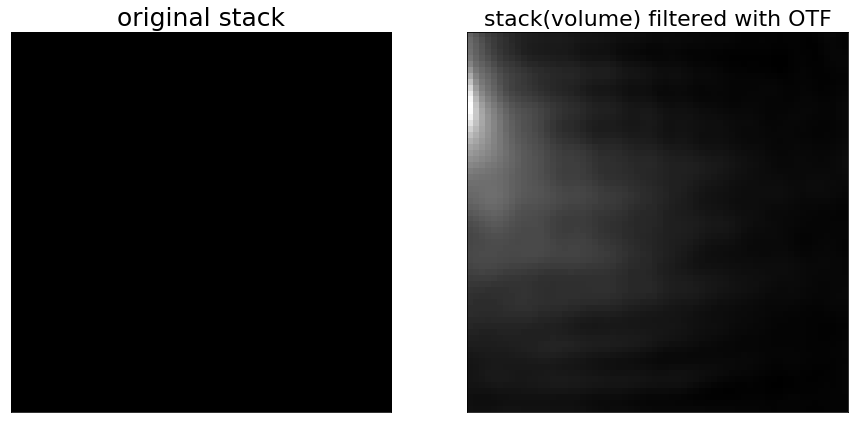

In [14]:
%matplotlib inline

# select a random stacks
i = np.random.randint(low=0, high=vol.shape[2], size=1)[0]
print('stack number:\t\t\t', i+1,'/',vol.shape[2])
img = vol[:,:,i]
img_otf = vol_otf[:,:,i]
# img_otf_tf = vol_otf_tf[:,:,i]

f = plt.figure(figsize=(15,10))
plt.subplot(121); plt.imshow(img, cmap='gray'); 
plt.xticks([]); plt.yticks([]); plt.title('original stack', fontsize=25)
plt.subplot(122); plt.imshow(img_otf, cmap='gray'); 
plt.xticks([]); plt.yticks([]); plt.title('stack(volume) filtered with OTF', fontsize=22)
# plt.subplot(133); plt.imshow(img_otf_tf, cmap='gray'); plt.xticks([]); plt.yticks([])
plt.show()

### plot entire volume and default PSF and try it with Christian's tool

(33, 512, 768)
(512, 768, 33)
volume shapes before / after: (512, 768, 33) / (33, 768, 512)
for change the stack use keys: {k,j}


<IPython.core.display.Javascript object>


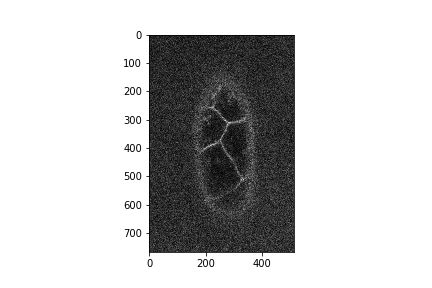

In [26]:
%matplotlib notebook

dub_path = '../data/3D/dub/dub01.tif'
dub = io.imread(dub_path)
print(dub.shape)
dub = hp.swapAxes(dub, swap=True)
print(dub.shape)

vol_3D = plot3D.Interactive_3DVolume(vol=dub)
vol_3D.multi_slice_viewer()

# Christians tool
 
# v = view(dub, show_hist=False)
# graph(vol_NIP[:,0,0])

### and initialize the volume to volume GAN

First we have a look for network-configuration.<br>
**Important configurations are:**
- manipulation of the stack axes (MANIPULATION_STACKS) -> influence on the quality of the image
- using GANHACK -> techniques for improve GAN training
- the NETWORK_DEPTH -> the depth has a large impact on the duration of the GAN-training

In [56]:
import json 
import pprint

with open('../scripts/config.json') as json_data:
    d = json.load(json_data)['selected']
    pprint.pprint(d)

{'ADD_GAUSS_NOISE_G': False,
 'ADD_MICRO_NOISE': True,
 'DATASET_NAME': 'VascuSynth',
 'DROPOUT': 0.25,
 'FLIP_LABEL_PROB': 0.4,
 'GANHACKS': True,
 'INPUT_NOISE_D': False,
 'LOSS': {'combined': ['mean_squared_error', 'mean_absolute_error'],
          'discriminator': 'mean_squared_error'},
 'MANIPULATION_STACKS': 'NONE',
 'NETWORK_DEPTH': 'MEDIUM',
 'ONE-SIDED-LABEL': 0.7,
 'OPTIMIZER': {'combined': 'adam',
               'discriminator': 'adam',
               'learning_rate': 0.0001,
               'loss_weights': [0, 10]},
 'PSF_OTF_NORM': 'OTF',
 'RESIZE': {'depth': 64, 'height': 64, 'width': 64},
 'SAVE_CONFIG': True,
 'SAVE_LOGS': False,
 'SAVE_LOSS': False,
 'SAVE_TABLE_IMAGES': True,
 'SAVE_VOLUME': True}


In [57]:
%%time

vol_orginal_size = (101,101,101) # (1024, 1024, 9)
print('volume orginial size:', vol_orginal_size)
print('volume cut (resize):', d['RESIZE'])
print('dataset name:', d['DATASET_NAME'], '\n___________________________________________________')

# from sklearn.model_selection import GridSearchCV
# param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=init)
# grid = GridSearchCV(estimator=model, param_grid=param_grid)

gan = p3p.Pix3Pix(vol_original=vol_orginal_size)

volume orginial size: (101, 101, 101)
volume cut (resize): {'width': 64, 'height': 64, 'depth': 64}
dataset name: VascuSynth 
___________________________________________________
discriminator-model in/output:	 (?, 64, 64, 64, 1) (?, 64, 64, 64, 1) 
				 (?, 8, 8, 8, 1)
generator-model input:		 (?, 64, 64, 64, 1)
downsampling:			 (?, 32, 32, 32, 64)
downsampling:			 (?, 16, 16, 16, 128)
downsampling:			 (?, 8, 8, 8, 256)
downsampling:			 (?, 4, 4, 4, 512)
downsampling:			 (?, 2, 2, 2, 512)
upsampling:			 (?, 4, 4, 4, 512)
upsampling:			 (?, 8, 8, 8, 256)
upsampling:			 (?, 16, 16, 16, 128)
upsampling:			 (?, 32, 32, 32, 64)
generator-model output:		 (?, 64, 64, 64, 1)
finish Pix3Pix __init__
Wall time: 3.33 s


### train volume to volume GAN

In [58]:
%%time
%matplotlib inline

epochs = 3

gan.train(epochs=epochs, batch_size=1, sample_interval=50)

[Epoch 0/2] [Batch 0/119] [D loss: 1.682941, acc:  12%] [G loss: 10.069187] time: 0:00:13.680787
[Epoch 0/2] [Batch 1/119] [D loss: 3.484497, acc:   9%] [G loss: 8.090307] time: 0:00:15.501932
[Epoch 0/2] [Batch 2/119] [D loss: 7.635695, acc:   5%] [G loss: 5.565693] time: 0:00:16.089366
[Epoch 0/2] [Batch 3/119] [D loss: 3.729814, acc:  11%] [G loss: 4.198772] time: 0:00:16.667090
[Epoch 0/2] [Batch 4/119] [D loss: 1.863193, acc:  16%] [G loss: 3.430470] time: 0:00:17.260695
[Epoch 0/2] [Batch 5/119] [D loss: 0.931288, acc:  17%] [G loss: 3.039898] time: 0:00:17.813031
[Epoch 0/2] [Batch 6/119] [D loss: 0.354701, acc:  34%] [G loss: 2.826493] time: 0:00:18.395364
[Epoch 0/2] [Batch 7/119] [D loss: 0.207065, acc:  38%] [G loss: 2.474634] time: 0:00:18.933560
[Epoch 0/2] [Batch 8/119] [D loss: 0.142606, acc:  40%] [G loss: 2.106326] time: 0:00:19.443869
[Epoch 0/2] [Batch 9/119] [D loss: 0.150848, acc:  40%] [G loss: 1.862927] time: 0:00:19.976241
[Epoch 0/2] [Batch 10/119] [D loss: 0.1

[Epoch 0/2] [Batch 85/119] [D loss: 0.179554, acc:  42%] [G loss: 0.068239] time: 0:01:02.727030
[Epoch 0/2] [Batch 86/119] [D loss: 0.178725, acc:  43%] [G loss: 0.050798] time: 0:01:03.277529
[Epoch 0/2] [Batch 87/119] [D loss: 0.173250, acc:  44%] [G loss: 0.040056] time: 0:01:03.822676
[Epoch 0/2] [Batch 88/119] [D loss: 0.176409, acc:  43%] [G loss: 0.049676] time: 0:01:04.364082
[Epoch 0/2] [Batch 89/119] [D loss: 0.172200, acc:  43%] [G loss: 0.051329] time: 0:01:04.915410
[Epoch 0/2] [Batch 90/119] [D loss: 0.174458, acc:  44%] [G loss: 0.049203] time: 0:01:05.464178
[Epoch 0/2] [Batch 91/119] [D loss: 0.174619, acc:  43%] [G loss: 0.053067] time: 0:01:05.993427
[Epoch 0/2] [Batch 92/119] [D loss: 0.175039, acc:  42%] [G loss: 0.030051] time: 0:01:06.547420
[Epoch 0/2] [Batch 93/119] [D loss: 0.170184, acc:  44%] [G loss: 0.027888] time: 0:01:07.081812
[Epoch 0/2] [Batch 94/119] [D loss: 0.169698, acc:  44%] [G loss: 0.029630] time: 0:01:07.631590
[Epoch 0/2] [Batch 95/119] [D 

[Epoch 1/2] [Batch 51/119] [D loss: 0.168769, acc:  45%] [G loss: 0.035722] time: 0:01:50.858188
[Epoch 1/2] [Batch 52/119] [D loss: 0.165415, acc:  45%] [G loss: 0.040081] time: 0:01:51.363338
[Epoch 1/2] [Batch 53/119] [D loss: 0.165777, acc:  46%] [G loss: 0.038612] time: 0:01:51.894445
[Epoch 1/2] [Batch 54/119] [D loss: 0.168672, acc:  44%] [G loss: 0.055558] time: 0:01:52.405190
[Epoch 1/2] [Batch 55/119] [D loss: 0.168322, acc:  45%] [G loss: 0.046428] time: 0:01:52.914678
[Epoch 1/2] [Batch 56/119] [D loss: 0.166774, acc:  45%] [G loss: 0.038503] time: 0:01:53.443723
[Epoch 1/2] [Batch 57/119] [D loss: 0.165138, acc:  45%] [G loss: 0.016557] time: 0:01:53.958304
[Epoch 1/2] [Batch 58/119] [D loss: 0.164243, acc:  46%] [G loss: 0.025097] time: 0:01:54.471917
[Epoch 1/2] [Batch 59/119] [D loss: 0.164945, acc:  46%] [G loss: 0.016377] time: 0:01:54.975205
[Epoch 1/2] [Batch 60/119] [D loss: 0.169434, acc:  45%] [G loss: 0.046568] time: 0:01:55.498448
[Epoch 1/2] [Batch 61/119] [D 

[Epoch 2/2] [Batch 17/119] [D loss: 0.161228, acc:  47%] [G loss: 0.018984] time: 0:02:37.055724
[Epoch 2/2] [Batch 18/119] [D loss: 0.163627, acc:  45%] [G loss: 0.033886] time: 0:02:37.560287
[Epoch 2/2] [Batch 19/119] [D loss: 0.161493, acc:  45%] [G loss: 0.024927] time: 0:02:38.081732
[Epoch 2/2] [Batch 20/119] [D loss: 0.163273, acc:  47%] [G loss: 0.034072] time: 0:02:38.593059
[Epoch 2/2] [Batch 21/119] [D loss: 0.163385, acc:  46%] [G loss: 0.049496] time: 0:02:39.095947
[Epoch 2/2] [Batch 22/119] [D loss: 0.163082, acc:  46%] [G loss: 0.037059] time: 0:02:39.611254
[Epoch 2/2] [Batch 23/119] [D loss: 0.162795, acc:  46%] [G loss: 0.040047] time: 0:02:40.112219
[Epoch 2/2] [Batch 24/119] [D loss: 0.160710, acc:  47%] [G loss: 0.014396] time: 0:02:40.626859
[Epoch 2/2] [Batch 25/119] [D loss: 0.160193, acc:  47%] [G loss: 0.017171] time: 0:02:41.153258
[Epoch 2/2] [Batch 26/119] [D loss: 0.159396, acc:  47%] [G loss: 0.027700] time: 0:02:41.667769
[Epoch 2/2] [Batch 27/119] [D 

[Epoch 2/2] [Batch 102/119] [D loss: 0.161086, acc:  45%] [G loss: 0.057340] time: 0:03:23.465145
[Epoch 2/2] [Batch 103/119] [D loss: 0.159594, acc:  48%] [G loss: 0.019407] time: 0:03:23.976476
[Epoch 2/2] [Batch 104/119] [D loss: 0.160228, acc:  47%] [G loss: 0.030645] time: 0:03:24.497073
[Epoch 2/2] [Batch 105/119] [D loss: 0.158943, acc:  47%] [G loss: 0.016943] time: 0:03:25.007483
[Epoch 2/2] [Batch 106/119] [D loss: 0.158417, acc:  48%] [G loss: 0.020274] time: 0:03:25.499723
[Epoch 2/2] [Batch 107/119] [D loss: 0.159384, acc:  47%] [G loss: 0.008195] time: 0:03:26.008035
[Epoch 2/2] [Batch 108/119] [D loss: 0.161297, acc:  47%] [G loss: 0.036677] time: 0:03:26.534694
[Epoch 2/2] [Batch 109/119] [D loss: 0.160796, acc:  47%] [G loss: 0.043845] time: 0:03:27.048981
[Epoch 2/2] [Batch 110/119] [D loss: 0.160069, acc:  47%] [G loss: 0.040718] time: 0:03:27.552086
[Epoch 2/2] [Batch 111/119] [D loss: 0.160044, acc:  47%] [G loss: 0.045465] time: 0:03:28.070881
[Epoch 2/2] [Batch 1

#### sample images from generator

In [22]:
p = time.strftime("%Y-%m-%d_%H_%M_%S")
gan.save_table_images(epoch=0, batch_i=0, p=p)

### release GPU memory

In [50]:
from keras import backend as K
import gc

K.clear_session()
gc.collect()

137191

In [51]:
delete_model_memory = False

if delete_model_memory:
    try:
        del gan, discriminator, combined, generator 
    except:
        print('models not available')

### plot random volume with 3 random stacks of GAN

plotted volume: images/VascuSynth\VascuSynth_2018-08-21_16_48_49\0_50.png


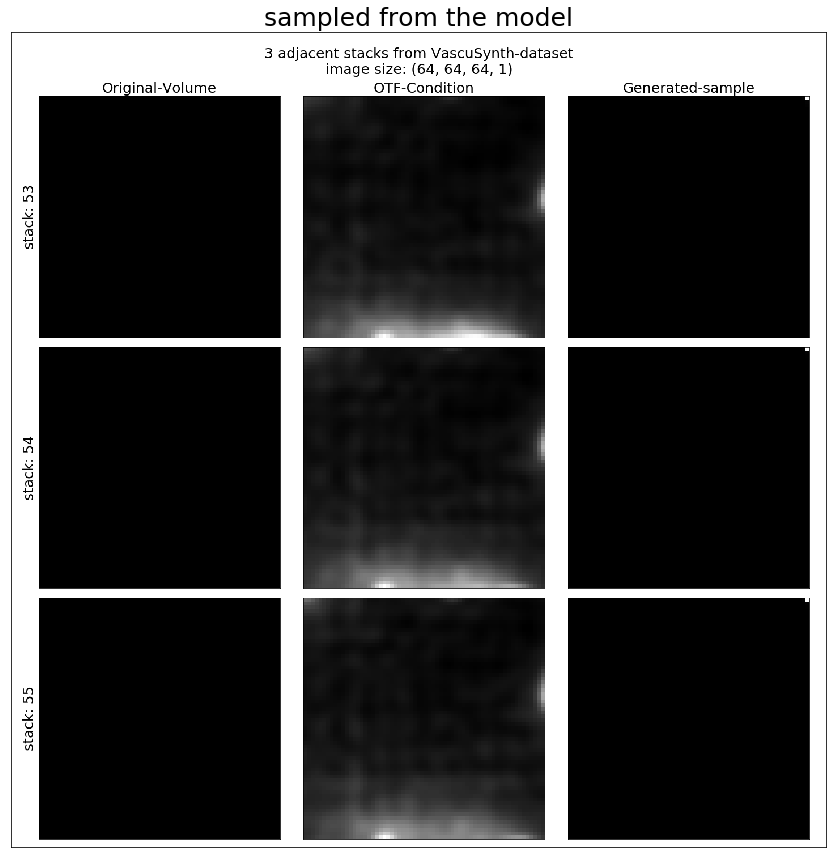

In [89]:
result_path = 'images/{0}/*'.format(dataset_name) 

model_vols = glob(result_path)
model_vols = [item for item in model_vols if not "_VOLUMES" in item]
selected_folder = model_vols[-1]+'/*'

volumes = glob(selected_folder)
volumes = np.random.choice(volumes, size=1)[0]
vol_plot = io.imread(volumes)

print('plotted volume:', volumes)
f = plt.figure(figsize=(15,15))
plt.imshow(vol_plot); plt.xticks([]); plt.yticks([]); plt.title('sampled from the model', fontsize=25);

### save/load models, gradients and parameters

In [ ]:
save_models = False

if save_models:
    hp.model_saver(model_instance=gan.discriminator, model_name='disc_10%')
    hp.model_saver(model_instance=gan.generator, model_name='gene_10%')
    hp.model_saver(model_instance=gan.combined, model_name='combined_10%')

In [ ]:
load_models = False

if load_models:
    disc_json, disc = hp.model_loader('2018_8_1', '10_44_00_disc_10%')

# create deconvolution model

tf.fft_shift needs even number of dims, so eventually cut an array (then create new otf)

In [ ]:
print(vol.shape, otf.shape)
vol_new = vol[:,:,:8]
otf_new = PSF3D(im=vol_new.shape, ret_val = 'OTF')
print(vol_new.shape, otf_new.shape)

In [ ]:
# otf = PSF3D(im=vol.shape, ret_val = 'OTF')
# deconvolution = deconv.Deconvolution_3D(img=vol_new, gan=gan_test, 
#                                         psf=otf_new, simulation=False)

### perform deconvolution model

In [ ]:
deconvolution.optimize()

#  TEST

(100, 100, 100)
[  0  31  63  95 127 159 191 223] (8,)
[ 15.12948592  15.15723555  15.23881145 ... 257.38577696 259.72488761
 262.28691323] (1000000,)
[  1   3   6  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65
  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83
  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173
 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191
 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209
 210 211 212 213 214 215 216 217 218 219 220 2

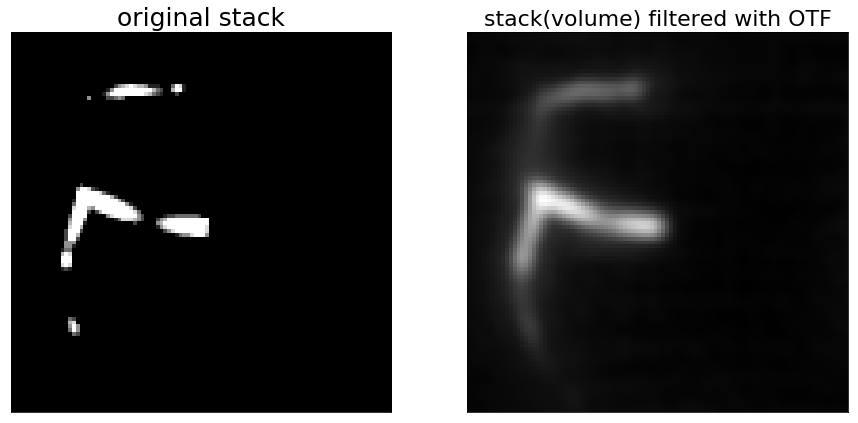

In [31]:
path = '../data/3D/VascuSynth/testVascuSynth11_101_101_101_uchar.tif'
vol = io.imread(path)
vol = vol[:-1,:-1,:-1]
print(vol.shape)

psf_temp = PSF3D(im=vol, ret_val = 'PSF')
psf_temp = psf_temp/np.sum(psf_temp)
otf_norm = np.fft.fftn(psf_temp)
# print(np.sum(psf_temp)) 

otf_norm = PSF3D(im=vol, ret_val='OTF')
vol_conv = deconv.conv3d_fft(vol, otf_norm)
# vol_conv = vol_conv.astype(np.uint8)

print(np.unique(vol), np.unique(vol).shape)
print(np.unique(vol_conv), np.unique(vol_conv).shape)
print(np.unique(vol_conv.astype(np.uint8)), np.unique(vol_conv.astype(np.uint8)).shape)

img = vol[:,:,50]
img_conv = vol_conv[:,:,50]

f = plt.figure(figsize=(15,10))
plt.subplot(121); plt.imshow(img, cmap='gray'); 
plt.xticks([]); plt.yticks([]); plt.title('original stack', fontsize=25)
plt.subplot(122); plt.imshow(img_conv, cmap='gray'); 
plt.xticks([]); plt.yticks([]); plt.title('stack(volume) filtered with OTF', fontsize=22)
plt.show()

In [6]:
%matplotlib notebook

volume shapes before / after: (64, 64, 64) / (64, 64, 64)
for change the stack use keys: {k,j}


<IPython.core.display.Javascript object>


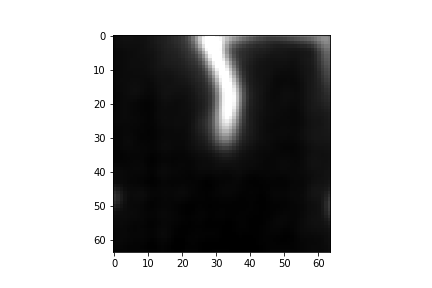

In [12]:
# p = './images/VascuSynth/VascuSynth_2018-08-22_17_49_33_VOLUMES/90_0_Original.tif'
p = './images/VascuSynth/VascuSynth_2018-08-22_17_49_33_VOLUMES/90_0_OTF.tif'
# p = './images/VascuSynth/VascuSynth_2018-08-22_17_49_33_VOLUMES/90_0_Generated.tif'
vol_generated = io.imread(p)

psf_3D = plot3D.Interactive_3DVolume(vol=vol_generated)
psf_3D.multi_slice_viewer()

In [17]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5127153118760145631, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6681632440
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15539279690425702166
 physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [ ]:
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant(3.0)
with tf.Session() as sess:
    print(sess.run(a))
        
# I believe that you need to set CUDA_VISIBLE_DEVICES=1. Or which ever GPU you want to use. 
#If you make only one GPU visible, you will refer to it as /gpu:0 regardless of what you set the environment variable to.
#More info on that environment variable: http://www.acceleware.com/blog/cudavisibledevices-masking-gpus

# https://stackoverflow.com/questions/40069883/how-to-set-specific-gpu-in-tensorflow

# if gpu > -1:
#     device = '/gpu:{}'.format(gpu)
# else:
#     device = '/cpu:0'

# with tf.device(device):
#     print('test')

In [ ]:
saver = tf.train.Saver(restore_sequentially=True)
saver_def = saver.as_saver_def()

In [53]:
from scipy.stats import poisson

a = np.random.randint(0,10, size=(4,4))
b = a.astype(float)/np.max(a)*10
c = np.random.poisson(b)
d = np.random.poisson(lam=.7, size=a.shape)
e = poisson.rvs(mu=.7, size=a.shape)

print(a)
print(b)
print(c)
print(d)
print(e)

print(a+(a*d))

[[2 0 6 3]
 [9 0 5 2]
 [1 9 9 3]
 [6 4 8 4]]
[[ 2.22222222  0.          6.66666667  3.33333333]
 [10.          0.          5.55555556  2.22222222]
 [ 1.11111111 10.         10.          3.33333333]
 [ 6.66666667  4.44444444  8.88888889  4.44444444]]
[[0 0 8 3]
 [7 0 5 5]
 [1 9 6 5]
 [5 3 9 2]]
[[0 0 0 1]
 [0 0 0 0]
 [0 0 1 0]
 [1 1 2 0]]
[[0 1 0 1]
 [1 1 0 1]
 [2 0 0 1]
 [1 2 1 3]]
[[ 2  0  6  6]
 [ 9  0  5  2]
 [ 1  9 18  3]
 [12  8 24  4]]
